# Tri-Agency Research Grants Analysis

This notebook analyzes grant data from Canada's three main research funding agencies:
- NSERC (Natural Sciences and Engineering Research Council)
- CIHR (Canadian Institutes of Health Research)
- SSHRC (Social Sciences and Humanities Research Council)

## 1. Setup and Data Collection

First, let's import required libraries and set up our environment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from data.fetcher import Fetcher, FetcherConfig

Now, let's fetch the grant data for 2019:

In [2]:
# Initialize fetcher with verbose output to see progress 
fetcher = Fetcher(FetcherConfig(verbose=True))

# Fetch 2019 data (latest amendment versions only)
year = '2019'
grants_df = fetcher.fetch_all_orgs(
    year=year,
    verify_ssl=False,
    handle_amendments='latest'
)

🚚 Starting tri-agency data fetch for 2019... 
  🔍 Fetching NSERC data... ✓ (12,080 records found)
  🔍 Fetching SSHRC data... ✓ (5,454 records found)
  🔍 Fetching CIHR data... ✓ (3,283 records found)

🔄️ Combining datasets... ✓
💾 Saved dataset to /u1/a9dutta/cs348/rgap/data/processed/tri_agency_grants_2019.csv

Dataset Summary
 - Total records: 20,817
 - Unique reference numbers: 20,817

Records per organization:
org
NSERC    12080
SSHRC     5454
CIHR      3283
Name: count, dtype: int64


## 2. Basic Analysis

Let's start with the built-in analysis functions:

In [3]:
if not grants_df.empty:
    analysis_results = fetcher.analyze_grants(grants_df)

🗃️ Performing grant analysis... 
  [1/4] Calculating summary by organization... ✓
  [2/4] Calculating provincial distribution... ✓
  [3/4] Identifying top recipients... ✓
  [4/4] Analyzing funding ranges... ✓

Analysis Results

Summary by Organization [2019]:


,# of Grants,Total Funding ($),Average Funding ($),Median Funding ($),# of Recipients
Organization,,,,,
CIHR,"3,283","$1,048,362,664.00","$319,330.69","$100,000.00","3,283"
NSERC,"12,080","$1,107,476,253.22","$91,678.50","$24,835.00","12,080"
SSHRC,"5,454","$1,091,804,708.96","$200,184.22","$40,000.00","5,454"



Funding Distribution by Province (and US States) [2019]:


,Province/State,CIHR (%),CIHR ($),NSERC (%),NSERC ($),SSHRC (%),SSHRC ($),Total ($)
1,ON,17.15%,"$446,072,258.00",16.18%,"$420,957,625.04",16.67%,"$433,601,394.00","$1,300,631,277.04"
2,QC,14.93%,"$252,215,465.00",18.01%,"$304,250,060.74",17.07%,"$288,430,484.00","$844,896,009.74"
3,BC,15.94%,"$135,056,692.00",16.54%,"$140,060,502.22",17.52%,"$148,399,388.00","$423,516,582.22"
4,AB,16.60%,"$108,619,902.00",17.59%,"$115,125,169.60",15.81%,"$103,486,962.00","$327,232,033.60"
5,MB,19.43%,"$36,183,744.00",16.74%,"$31,163,501.67",13.83%,"$25,758,858.96","$93,106,104.63"
6,NS,15.00%,"$25,704,307.00",15.77%,"$27,026,815.72",19.23%,"$32,954,808.00","$85,685,930.72"
7,SK,11.86%,"$16,857,461.00",19.11%,"$27,165,964.58",19.04%,"$27,066,862.00","$71,090,287.58"
8,NL,15.43%,"$9,528,417.00",19.77%,"$12,211,639.32",14.80%,"$9,141,381.00","$30,881,437.32"
9,NB,2.80%,"$1,512,270.00",23.81%,"$12,857,896.20",23.39%,"$12,631,818.00","$27,001,984.20"
10,NT,25.14%,"$3,635,200.00",21.75%,"$3,145,050.00",3.11%,"$449,543.00","$7,229,793.00"



Top 10 Recipients by Funding [2019]:


,Recipient,Total Funding ($),Number of Agreements,Average Funding ($),Organizations
1,University of Toronto - University of Toronto,"$46,525,808.00",1,"$46,525,808.00",SSHRC
2,"Chertkow, Howard M","$31,625,000.00",1,"$31,625,000.00",CIHR
3,The University of British Columbia - The University of British Columbia,"$28,384,162.00",1,"$28,384,162.00",SSHRC
4,McGill University - Université McGill,"$27,180,649.00",1,"$27,180,649.00",SSHRC
5,"Anis, Aslam H","$22,850,000.00",1,"$22,850,000.00",CIHR
6,University of Alberta - University of Alberta,"$17,872,608.00",1,"$17,872,608.00",SSHRC
7,Université de Montréal - Université de Montréal,"$17,858,583.00",1,"$17,858,583.00",SSHRC
8,Université Laval - Université Laval,"$14,124,963.00",1,"$14,124,963.00",SSHRC
9,University of Ottawa - Université d'Ottawa,"$14,095,015.00",1,"$14,095,015.00",SSHRC
10,McMaster University - McMaster University,"$13,900,412.00",1,"$13,900,412.00",SSHRC



Funding Range Distribution [2019]:


,0-10K,10K-50K,50K-100K,100K-500K,500K+
Organization,,,,,
CIHR,755,723,220,886,692
NSERC,"4,481","3,189",921,"3,219",257
SSHRC,215,"2,732","1,083","1,216",208


## 3. Additional Analysis

### 3.1 Temporal Distribution

Let's look at how grants are distributed across months:

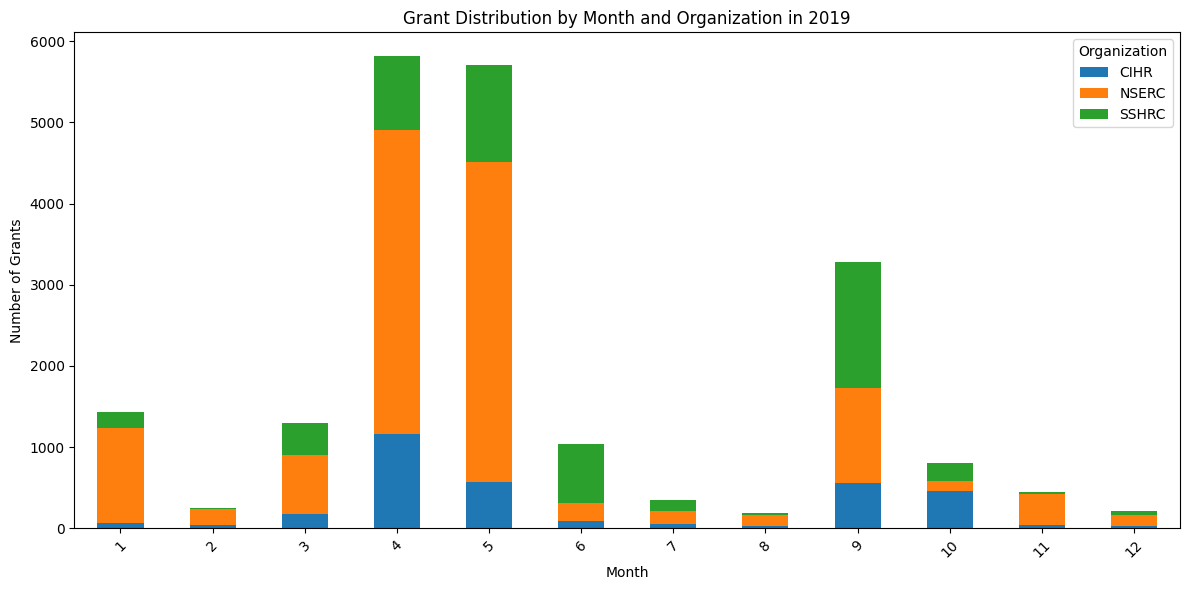

In [8]:
# Convert dates to datetime and extract month
grants_df['start_month'] = pd.to_datetime(grants_df['agreement_start_date']).dt.month

# Plot monthly distribution by organization
fig, ax = plt.subplots(figsize=(12, 6))
monthly_dist = grants_df.pivot_table(
    index='start_month', 
    columns='org', 
    values='ref_number', 
    aggfunc='count'
).fillna(0)

monthly_dist.plot(kind='bar', stacked=True, ax=ax)
ax.set_title(f'Grant Distribution by Month and Organization in {year}')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Grants')
ax.legend(title='Organization')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Grant Value Distributions
Let's examine the distribution of grant values:

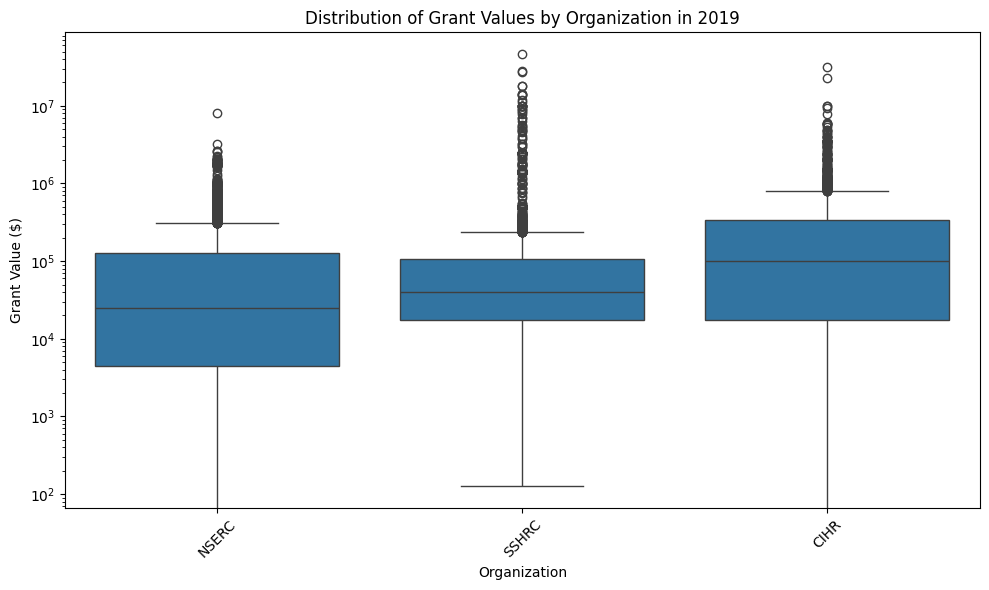

In [5]:
# Create box plot of grant values by organization
plt.figure(figsize=(10, 6))
sns.boxplot(data=grants_df, x='org', y='agreement_value')
plt.xlabel('Organization')
plt.ylabel('Grant Value ($)')
plt.title(f'Distribution of Grant Values by Organization in {year}')
plt.ylabel('Grant Value ($)')
plt.yscale('log')  # Use log scale due to large range
plt.xticks(rotation=45)
plt.tight_layout()

### 3.3 Geographic Analysis

Let's analyze the geographic distribution of funding:

In [6]:
# Calculate total funding by province for each organization
province_funding = grants_df.pivot_table(
    index='recipient_province',
    columns='org',
    values='agreement_value',
    aggfunc='sum'
).fillna(0)

# Calculate total for each province
province_funding['Total'] = province_funding.sum(axis=1)

# Calculate percentage distribution
province_pct = province_funding.div(province_funding.sum()) * 100

# Create combined DataFrame with single index
combined_data = pd.DataFrame(index=province_funding.index)

# Fill in the data
orgs = ['CIHR', 'NSERC', 'SSHRC']
for org in orgs:
    combined_data[f'{org} (%)'] = province_pct[org]
    combined_data[f'{org} ($)'] = province_funding[org]

# Add total funding as a single column
combined_data['Total ($)'] = province_funding['Total']

# Sort by total funding descending
combined_data = combined_data.sort_values('Total ($)', ascending=False).reset_index()
combined_data.index += 1
combined_data.rename(columns={'recipient_province': 'Province/State'}, inplace=True)

# Center the column names
styles = [
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]}
]

print(f'\nFunding Distribution by Province (and US States) in {year}:')
display(combined_data.style
        .set_table_styles(styles)
        .format({
            'Total ($)': '${:,.2f}',
            'CIHR (%)': '{:,.2f}%',
            'NSERC (%)': '{:,.2f}%',
            'SSHRC (%)': '{:,.2f}%',
            'CIHR ($)': '${:,.2f}',
            'NSERC ($)': '${:,.2f}',
            'SSHRC ($)': '${:,.2f}'
        }))


Funding Distribution by Province (and US States) in 2019:


,Province/State,CIHR (%),CIHR ($),NSERC (%),NSERC ($),SSHRC (%),SSHRC ($),Total ($)
1,ON,42.91%,"$446,072,258.00",38.05%,"$420,957,625.04",39.87%,"$433,601,394.00","$1,300,631,277.04"
2,QC,24.26%,"$252,215,465.00",27.50%,"$304,250,060.74",26.52%,"$288,430,484.00","$844,896,009.74"
3,BC,12.99%,"$135,056,692.00",12.66%,"$140,060,502.22",13.65%,"$148,399,388.00","$423,516,582.22"
4,AB,10.45%,"$108,619,902.00",10.41%,"$115,125,169.60",9.52%,"$103,486,962.00","$327,232,033.60"
5,MB,3.48%,"$36,183,744.00",2.82%,"$31,163,501.67",2.37%,"$25,758,858.96","$93,106,104.63"
6,NS,2.47%,"$25,704,307.00",2.44%,"$27,026,815.72",3.03%,"$32,954,808.00","$85,685,930.72"
7,SK,1.62%,"$16,857,461.00",2.46%,"$27,165,964.58",2.49%,"$27,066,862.00","$71,090,287.58"
8,NL,0.92%,"$9,528,417.00",1.10%,"$12,211,639.32",0.84%,"$9,141,381.00","$30,881,437.32"
9,NB,0.15%,"$1,512,270.00",1.16%,"$12,857,896.20",1.16%,"$12,631,818.00","$27,001,984.20"
10,NT,0.35%,"$3,635,200.00",0.28%,"$3,145,050.00",0.04%,"$449,543.00","$7,229,793.00"


### 3.4 Recipient Analysis

Let's look at the top recipients by total funding:

In [7]:
# Group by recipient and calculate metrics
recipient_metrics = grants_df.groupby('recipient_legal_name').agg({
    'agreement_value': ['sum', 'count', 'mean'],
    'org': lambda x: ', '.join(sorted(set(x)))
}).round(2)

# Flatten the multi-index columns
recipient_metrics.columns = ['Total Funding ($)', 'Number of Agreements', 'Average Funding ($)', 'Organization']

# Sort by total funding
top_recipients = recipient_metrics.sort_values('Total Funding ($)', ascending=False).head(15)

# Add rank/index
top_recipients = top_recipients.reset_index()
top_recipients.index = top_recipients.index + 1

print(f'\nTop 15 Recipients by Total Funding in {year}:')
display(top_recipients.style.format({
    'Total Funding ($)': "${:,.2f}",
    'Average Funding ($)': "${:,.2f}",
    'Number of Agreements': "{:,}"
}))


Top 15 Recipients by Total Funding in 2019:


,recipient_legal_name,Total Funding ($),Number of Agreements,Average Funding ($),Organization
1,University of Toronto - University of Toronto,"$46,525,808.00",1,"$46,525,808.00",SSHRC
2,"Chertkow, Howard M","$31,625,000.00",1,"$31,625,000.00",CIHR
3,The University of British Columbia - The University of British Columbia,"$28,384,162.00",1,"$28,384,162.00",SSHRC
4,McGill University - Université McGill,"$27,180,649.00",1,"$27,180,649.00",SSHRC
5,"Anis, Aslam H","$22,850,000.00",1,"$22,850,000.00",CIHR
6,University of Alberta - University of Alberta,"$17,872,608.00",1,"$17,872,608.00",SSHRC
7,Université de Montréal - Université de Montréal,"$17,858,583.00",1,"$17,858,583.00",SSHRC
8,Université Laval - Université Laval,"$14,124,963.00",1,"$14,124,963.00",SSHRC
9,University of Ottawa - Université d'Ottawa,"$14,095,015.00",1,"$14,095,015.00",SSHRC
10,McMaster University - McMaster University,"$13,900,412.00",1,"$13,900,412.00",SSHRC


## 4. Findings and Insights

Some key observations from our analysis:
1. **Temporal Patterns**: [Add insights about monthly distribution]
2. **Funding Distribution**: [Add insights about funding patterns]
3. **Geographic Concentration**: [Add insights about provincial distribution]
4. **Institutional Leadership**: [Add insights about top institutions]

## 5. Next Steps

Potential areas for deeper analysis:
1. Year-over-year comparison (2018-2023)
2. Research field analysis using grant titles/descriptions
3. Network analysis of institutions and researchers
4. Success rate analysis for different demographics
5. Impact analysis using citation data (if available)